##### Differences to previous version:
- 3 actions: left, right, stay
- actions are performed over longer time spans
- fixed number of boxes
- boxes are moving

In [1]:
bar_kwargs = {'lw': 0, 'color': '#206090'}
line_kwargs = {'lw': 3, 'color': '#206090'}

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from reduceddynamics import create_sequence, create_seq_data, create_seq_data_complex, plot_percepts,\
                            bigbox_world_generator, World, recursive_prediction

### Create data

All slots are independently set to 0 or 1 with probability $p$.
Set $p = 0.5$ for maximum Entropy. 

In [4]:
world_size = 46
box_size = 4
n_boxes = 3
box_speedlimits = (-2, 2)
window_size = 18
rng = np.random.RandomState(123)
sequence_length = 200
n_train = 100000
n_test = 1000

action_duration = (5, 10)

# n_sequences = n_train + n_test

assert world_size >= window_size, 'Window must be at least as big as world.'

In [5]:
seq_params = {'world': World(world_size, n_boxes, box_size, box_speedlimits, rng),
              'window_size': window_size, 
              'sequence_length': sequence_length, 
              'rng': rng, 
              'action_duration': action_duration,
              'dtype': 'int16'}

x_train, y_train = create_seq_data_complex(n_sequences=n_train, 
                                           return_world=False,
                                           **seq_params)
x_test, y_test, world_test, positions_test = create_seq_data_complex(n_sequences=n_test, 
                                               return_world=True,
                                               **seq_params)




#### Probability of one full turn (Monte Carlo) 

In [6]:
lengths = [k for k in xrange(0, 120)]
probs = []
sample_n = 1000
for sequence_length in lengths:
    pos = 0
    results = []
    for i in xrange(sample_n):
        visited = np.zeros(world_size, dtype='int16')
        next_action_countdown = 0
        current_action = 0
        for j in xrange(sequence_length):
            if next_action_countdown == 0:
                current_action = rng.randint(0, 2) - 1
                next_action_countdown = rng.randint(*action_duration)
            pos = (pos + current_action) % world_size
            visited[pos] = 1
            next_action_countdown -= 1
        results.append(1 if np.sum(visited) == world_size else 0)
    probs.append(np.mean(results))

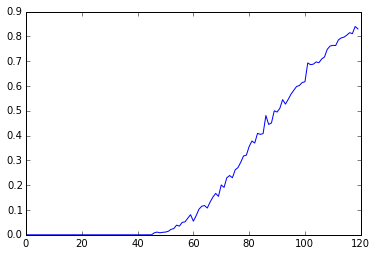

In [7]:
plt.plot(lengths, probs)
plt.show()

### Visualize data

In [8]:
b = 2
i = 8
print x_train[b, i, :-1]
print x_train[b, i, -1]
print y_train[b, i]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


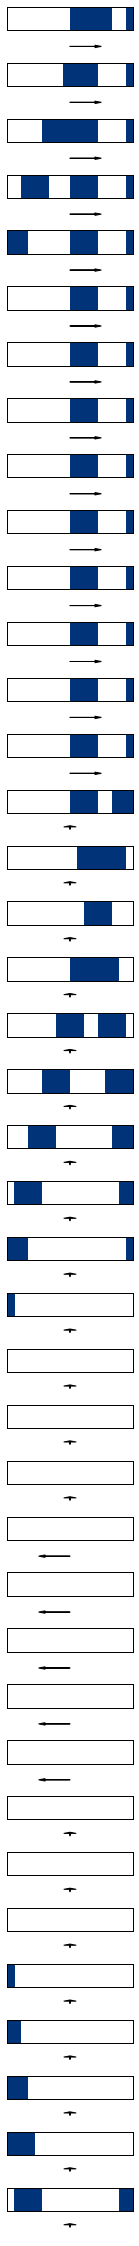

In [14]:
b = 10
n = 40
plot_percepts(np.array(x_train[b, :n, :-1]), actions=x_train[b, :n, -1], box_width=box_size)
pass

### Train recurrent network to learn dynamics 

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, TimeDistributedDense
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

In [15]:
n_hidden = 400

In [16]:
model = Sequential()
model.add(LSTM(output_dim=n_hidden, input_dim=window_size+1,
               return_sequences=True))

# model.add(LSTM(output_dim=n_hidden,
#                return_sequences=True))

# model.add(LSTM(output_dim=percept_length, activation='tanh', inner_activation='hard_sigmoid',
#               return_sequences=True))
# model.add(TimeDistributedDense(output_dim=n_hidden, input_dim=window_size+1))
# model.add(Activation('sigmoid'))
model.add(TimeDistributedDense(window_size))
model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [30]:
model.fit(x_train, y_train, batch_size=16, nb_epoch=100,
          validation_split=0.1,
          callbacks=[early_stopping])

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
89984/90000 [============================>.] - ETA: 0s - loss: 0.0023

KeyboardInterrupt: 

### Evaluate Model performance 

#### Loss on test set

In [31]:
print model.evaluate(x_test, y_test, batch_size=16)

1000/1000 [==============================] - 12s    
0.00217488831095


#### Error rate

We round the result to the nearest integer and consider the prediction to be erroneous if at least one slot is predicted incorrectly.

In [32]:
pred = model.predict(x_test)

In [33]:
overall_error_rate = 1-np.mean(np.prod(np.round(1 - np.abs(pred - y_test)), axis=2))
position_error_rate = np.mean(np.abs(np.round(pred) - y_test))
late_error_rate = 1-np.mean(np.prod(np.round(1 - np.abs(pred[:, (pred.shape[1]/2):, :] - y_test[:, (pred.shape[1]/2):, :])), axis=2))

In [34]:
print 'Overall error rate: {0}'.format(overall_error_rate)
print 'Position error rate: {0}'.format(position_error_rate)
print 'Late error rate: {0}'.format(late_error_rate)

Overall error rate: 0.03419
Position error rate: 0.0026875
Late error rate: 0.01792


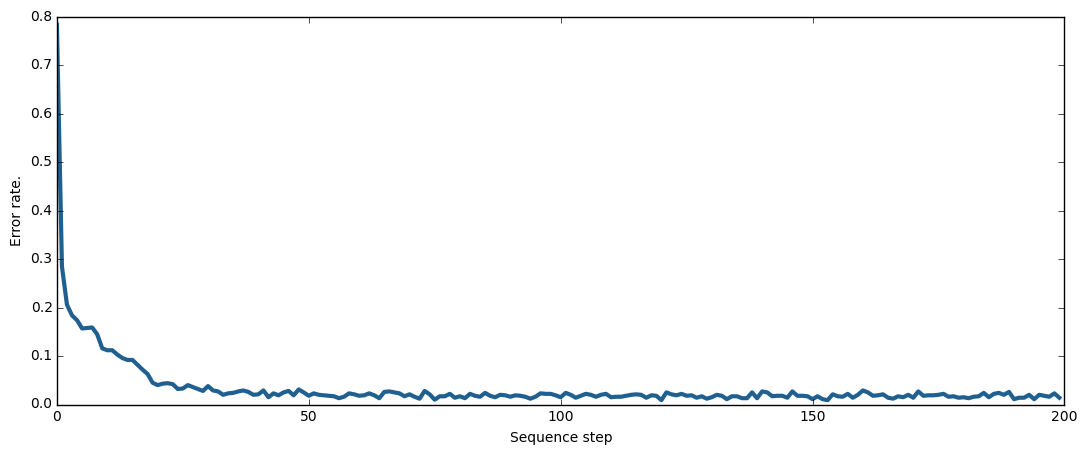

In [35]:
binary_errors = np.prod(np.round(1 - np.abs(pred - y_test)), axis=2)
binary_error_rate_wrt_time = 1 - np.mean(binary_errors, axis=0)

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(111)
ax.plot(binary_error_rate_wrt_time, **line_kwargs)
ax.set_xlabel('Sequence step')
ax.set_ylabel('Error rate.')
plt.show()

In [36]:
print 'Error rate at first time step: {0}'.format(binary_error_rate_wrt_time[0])

Error rate at first time step: 0.784


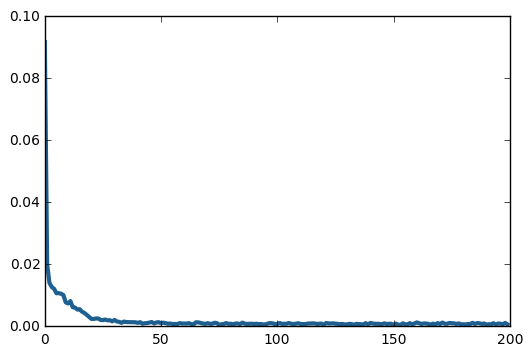

In [37]:
error_wrt_time = np.mean(np.mean((y_test - pred) ** 2, axis=0), axis=1)
plt.plot(error_wrt_time, **line_kwargs)
plt.show()

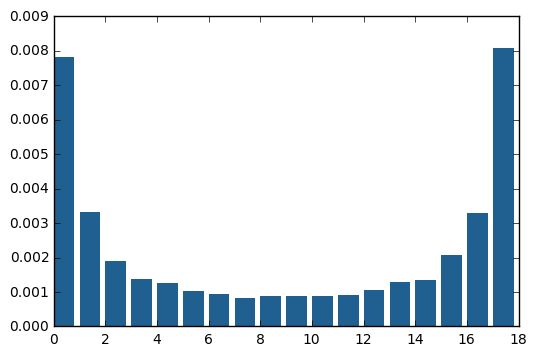

In [38]:
error_wrt_pos = np.mean(np.mean((y_test - pred) ** 2, axis=0), axis=0)
plt.bar(np.arange(len(error_wrt_pos)), error_wrt_pos, **bar_kwargs)
plt.show()

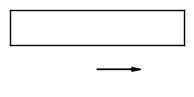

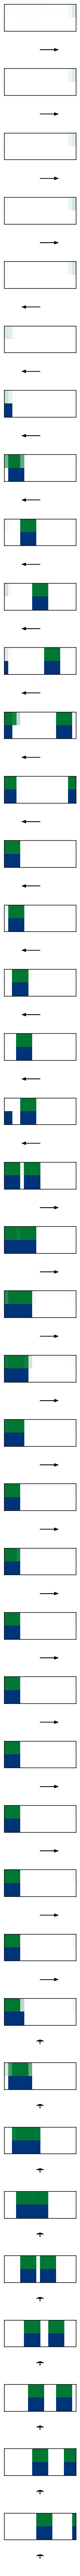

In [39]:
b = 3
n = 40

plot_percepts(x_test[b, :1, :-1], actions=x_test[b, 0:1, -1], box_width=box_size)

plot_percepts(y_test[b, :n], actions=x_test[b, 1:n+1, -1], predictions=pred[b, :n], box_width=box_size)
pass

In [40]:
import matplotlib
reload(matplotlib)
from animations import make_anim
from datetime import datetime

(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)
(2, 30, 18) (30, 18)


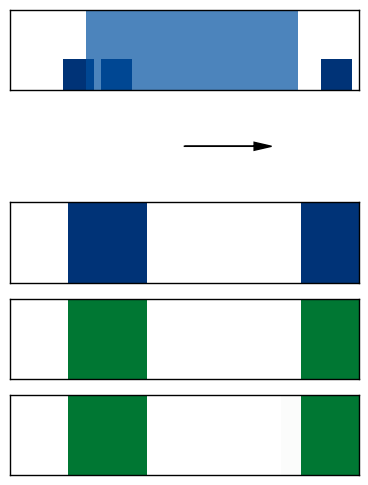

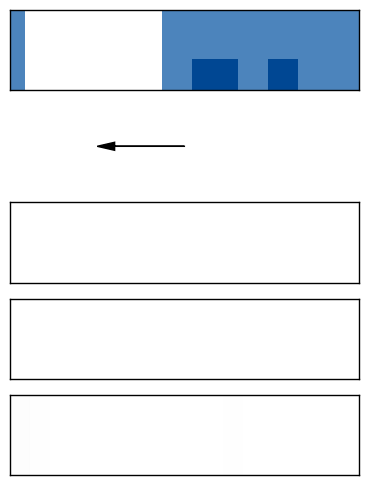

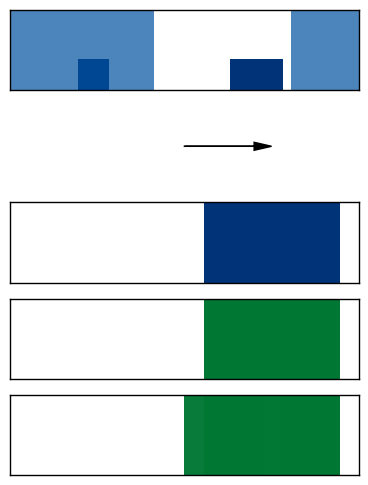

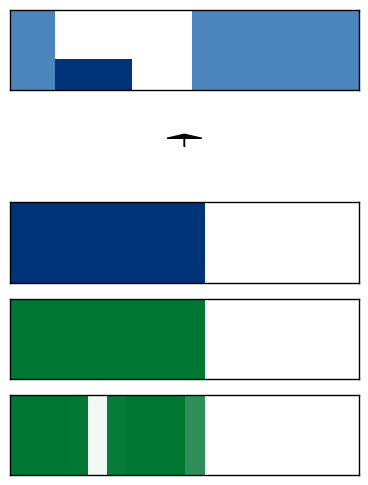

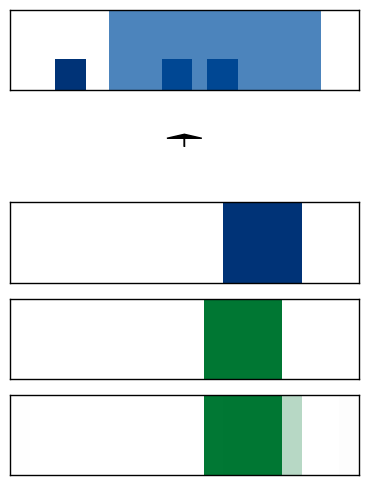

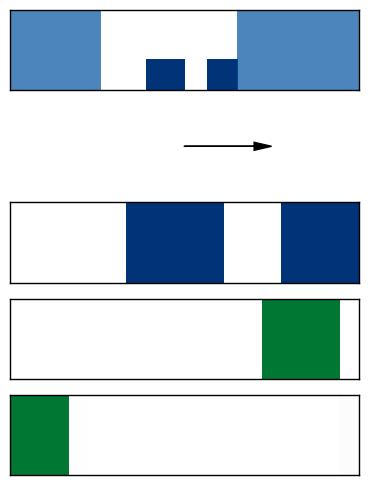

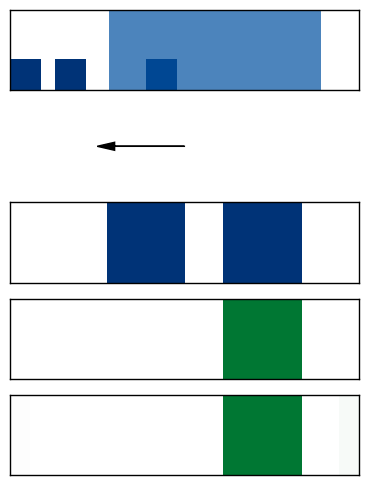

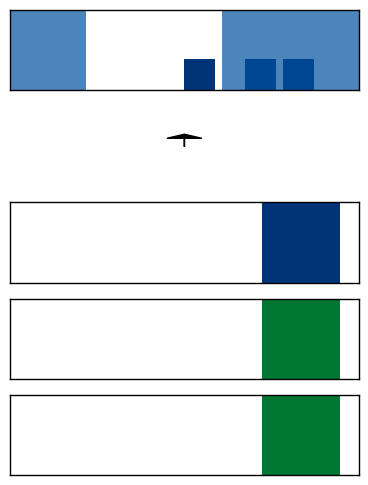

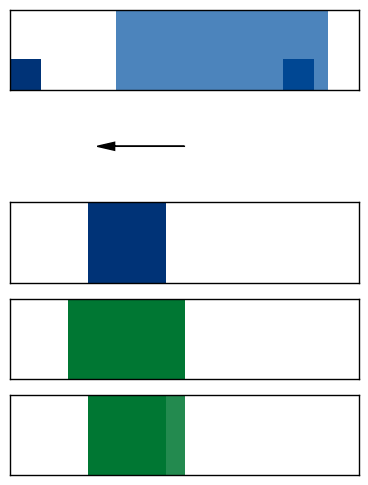

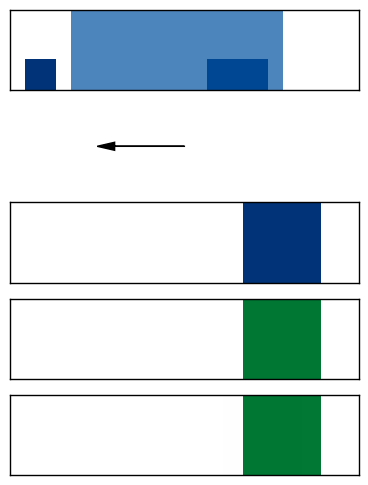

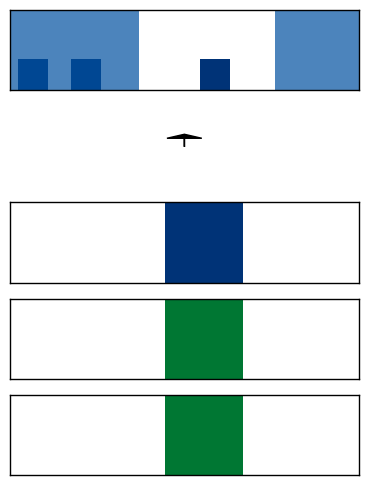

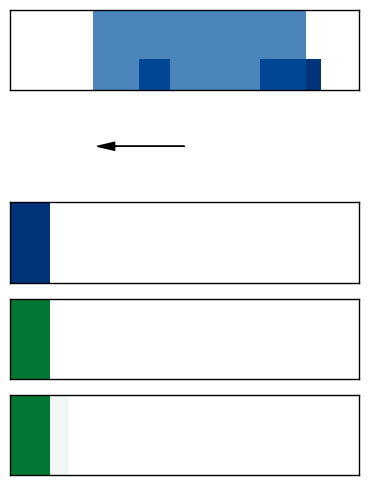

In [41]:
for b in xrange(20, 32):
    n_init = rng.randint(1, 60)
    n_pred = 30

    pre_xs = x_test[b, 0:n_init]
    pre_percepts = pre_xs[:, :-1]
    post_percepts = x_test[b, n_init: n_init+n_pred, :-1]
    actions = x_test[b, :n_init+n_pred, -1]
    subsequent_actions = actions[n_init:]
    world_states = world_test[b, :n_init+n_pred]
    positions = positions_test[b, :n_init+n_pred]

    rec_pred_round = recursive_prediction(model, pre_xs, subsequent_actions,
                                          pred_mode='round')
    # rec_preds_sample = [recursive_prediction(model, pre_xs, subsequent_actions,
    #                                          pred_mode='sample', rng=rng)
    #                     for i in xrange(3)]
    rec_pred_raw = recursive_prediction(model, pre_xs, subsequent_actions,
                                        pred_mode='none')

    make_anim(filename='movies/big_world_bm/anim_' + datetime.now().strftime('%Y%m%d%H%M') + '_' + str(b) + '_' + str(n_init) + '.mp4', 
              pre_percepts=pre_percepts, 
              post_percepts=post_percepts,
          predictions=np.asarray([rec_pred_round] + [rec_pred_raw]),
          actions=actions,
          world_states=world_states,
          positions=positions,
          box_width=box_size
         )